In [1]:
import os
import sys
import pickle
import numpy as np
from math import exp
from scipy import stats
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from vizsequence.viz_sequence import plot_weights_given_ax
from scipy.special import softmax
import keras
import keras.losses
from keras.models import Model, Sequential, load_model
from keras import backend as K
import numpy.random as rng
import seaborn as sns
from collections import OrderedDict
from basepair.losses import twochannel_multinomial_nll
import modisco
import modisco.tfmodisco_workflow.workflow
from modisco.tfmodisco_workflow import workflow
import h5py
import modisco.util
from collections import Counter
from modisco.visualization import viz_sequence
import modisco.affinitymat.core
import modisco.cluster.phenograph.core
import modisco.cluster.phenograph.cluster
import modisco.cluster.core
import modisco.aggregator
%matplotlib inline

Using TensorFlow backend.
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/amr1/mi

2020-11-05 06:36:26,941 [WARNING] From /users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

TF-MoDISco is using the TensorFlow backend.


In [2]:
all_post_counts_hypimps = np.load("/users/amr1/pho4/data/imp-scores/er/e2/post_counts_hypimps.npy")
all_post_counts_actualimps = np.load("/users/amr1/pho4/data/imp-scores/er/e2/post_counts_actualimps.npy")  
all_seqs = np.load("/users/amr1/pho4/data/imp-scores/er/e2/seqs.npy")

In [3]:
track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
                task_names=["task0"],
                contrib_scores={"task0": all_post_counts_actualimps},
                hypothetical_contribs={"task0": all_post_counts_hypimps},
                one_hot=all_seqs)

grp = h5py.File("/users/amr1/pho4/data/modisco/er/e2/task0_counts_results.hdf5","r")
loaded_tfmodisco_results =\
    workflow.TfModiscoResults.from_hdf5(grp, track_set=track_set)
grp.close()

Untrimmed - sequence (scaled by information content)


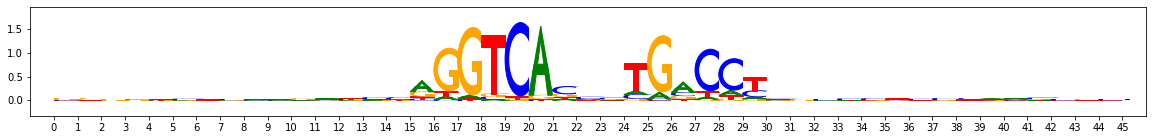

Untrimmed - task 0 hypothetical scores


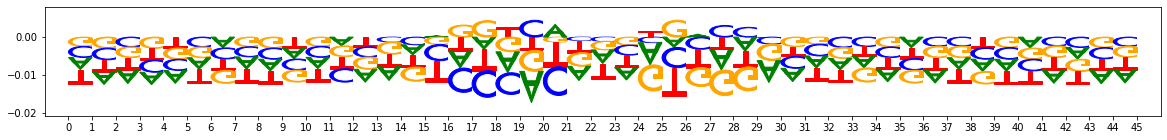

IC-trimmed - sequence (scaled by information content)


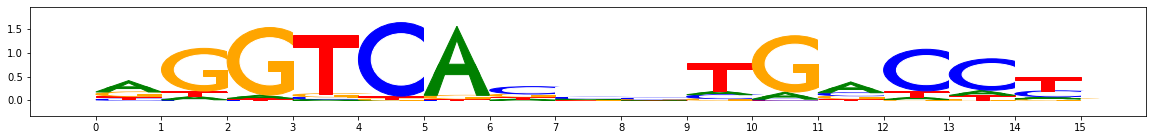

In [4]:
background = np.array([0.27, 0.23, 0.23, 0.27])
untrimmed_pattern = (
    loaded_tfmodisco_results
    .metacluster_idx_to_submetacluster_results["metacluster_1"]
    .seqlets_to_patterns_result.patterns[1])
print("Untrimmed - sequence (scaled by information content)")
viz_sequence.plot_weights(viz_sequence.ic_scale(untrimmed_pattern["sequence"].fwd, background=background))
print("Untrimmed - task 0 hypothetical scores")
viz_sequence.plot_weights(untrimmed_pattern["task0_hypothetical_contribs"].fwd)
trimmed = untrimmed_pattern.trim_by_ic(ppm_track_name="sequence", background=background, threshold=0.3)
print("IC-trimmed - sequence (scaled by information content)")
viz_sequence.plot_weights(viz_sequence.ic_scale(trimmed["sequence"].fwd, background=background))

In [5]:
print(trimmed["task0_hypothetical_contribs"].fwd)

[[ 3.52988090e-04 -4.32122378e-03 -1.92421803e-03 -5.74216966e-03]
 [-4.51009357e-03 -6.42599526e-03  3.18512543e-03 -3.67007374e-03]
 [-3.25467332e-03 -7.06618283e-03  4.36368361e-03 -5.59716280e-03]
 [-5.52894793e-03 -5.74433653e-03 -3.88717615e-03  2.79282234e-03]
 [-8.27319005e-03  4.45503283e-03 -5.56121278e-03 -3.50169711e-03]
 [ 3.37694773e-03 -7.60520337e-03 -1.30556881e-03 -6.51964807e-03]
 [-3.76389985e-03 -9.01278269e-04 -3.61297346e-03 -3.19915492e-03]
 [-3.59831550e-03 -1.12324025e-03 -2.25521326e-03 -4.04215649e-03]
 [-3.34008417e-03 -2.63761701e-03 -2.11183352e-03 -3.25014702e-03]
 [-5.87482237e-03 -1.46755303e-03 -6.90828568e-03  1.63701597e-03]
 [-2.74202531e-03 -5.34389326e-03  4.47259453e-03 -7.55783152e-03]
 [ 7.81386549e-04 -3.20684542e-03 -5.01140522e-03 -4.83853113e-03]
 [-5.46416609e-03  3.07984973e-03 -6.75092662e-03 -3.24516812e-03]
 [-3.77406733e-03  2.58237721e-03 -6.35189207e-03 -4.09893359e-03]
 [-5.77615094e-03 -1.82850024e-03 -4.38121571e-03  1.21530163e

In [6]:
imp_scores = all_post_counts_actualimps
onehot_seq = np.array(all_seqs)
fwd_masked_cosine_sim = modisco.util.compute_masked_cosine_sim(
                                     imp_scores=imp_scores,
                                     onehot_seq=onehot_seq,
                                     weightmat=trimmed["task0_hypothetical_contribs"].fwd)
rev_masked_cosine_sim = modisco.util.compute_masked_cosine_sim(
                                     imp_scores=imp_scores,
                                     onehot_seq=onehot_seq,
                                     weightmat=trimmed["task0_hypothetical_contribs"].rev)

#We take the max of the masked_cosine_sim on the fwd and reverse strands
is_fwd_masked_cosine_sim = fwd_masked_cosine_sim > rev_masked_cosine_sim
masked_cosine_sim = (fwd_masked_cosine_sim*is_fwd_masked_cosine_sim
                     + rev_masked_cosine_sim*(is_fwd_masked_cosine_sim==False))

#Also look at the total sum of scores in each window
sum_scores = modisco.util.compute_sum_scores(imp_scores=imp_scores,
                                             window_size=len(trimmed["task0_hypothetical_contribs"].fwd))

/users/amr1/tfmodisco/modisco/util.py:497: RuntimeWarning: invalid value encountered in true_divide
  norm_deeplift_scores*norm_masked_weightmat)
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in greater


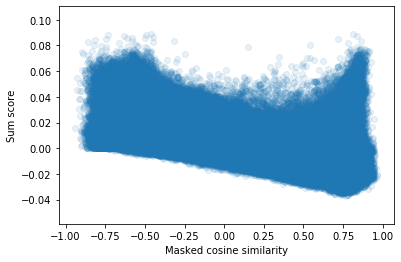

In [7]:
plt.scatter(masked_cosine_sim.ravel(), sum_scores.ravel(), alpha=0.1)
plt.xlabel("Masked cosine similarity")
plt.ylabel("Sum score")
plt.show()

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


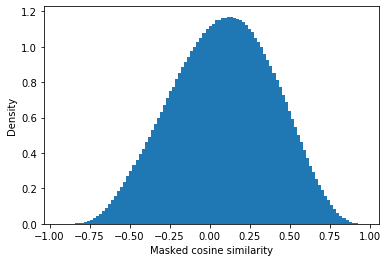

In [8]:
plt.hist(masked_cosine_sim.ravel(), bins=100, density=True)
plt.xlabel("Masked cosine similarity")
plt.ylabel("Density")
plt.show()

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


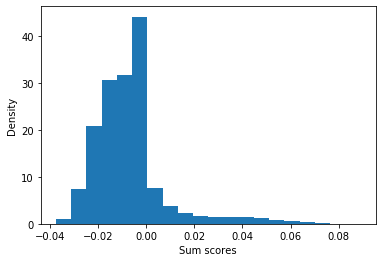

In [24]:
masked_cosine_sim_thresh = 0.75
plt.hist(sum_scores.ravel()[masked_cosine_sim.ravel() > masked_cosine_sim_thresh],
         bins=20, density=True)
plt.xlabel("Sum scores")
plt.ylabel("Density")
plt.show()

In [25]:
sum_score_thresh = 0.05
threshold_passers = ((masked_cosine_sim > masked_cosine_sim_thresh)*
                     (sum_scores > sum_score_thresh))

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


In [26]:
hit_locations = list(zip(*np.nonzero(threshold_passers)))
len(hit_locations)

702

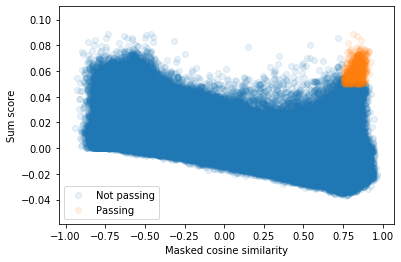

In [27]:
handles = []
handles.append(
    plt.scatter(masked_cosine_sim[threshold_passers==False].ravel(),
            sum_scores[threshold_passers==False].ravel(), alpha=0.1))
handles.append(
    plt.scatter(masked_cosine_sim[threshold_passers].ravel(),
            sum_scores[threshold_passers].ravel(), alpha=0.1))
plt.xlabel("Masked cosine similarity")
plt.ylabel("Sum score")
plt.legend(handles=handles, labels=["Not passing", "Passing"])
plt.show()

cosine similarity: 0.7720857279102589 sum scores: 0.05080462665864616


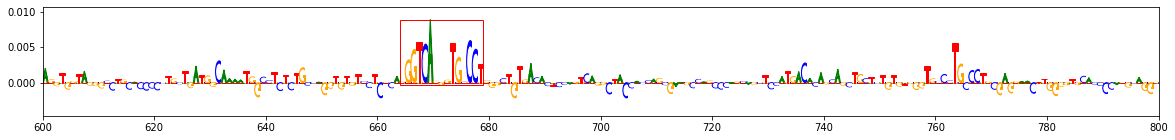

cosine similarity: 0.8139159104571211 sum scores: 0.06298697296770114


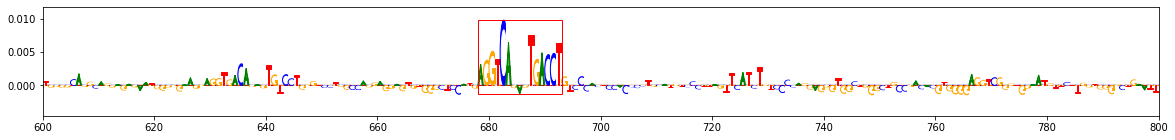

cosine similarity: 0.8251867099052849 sum scores: 0.05983975889294015


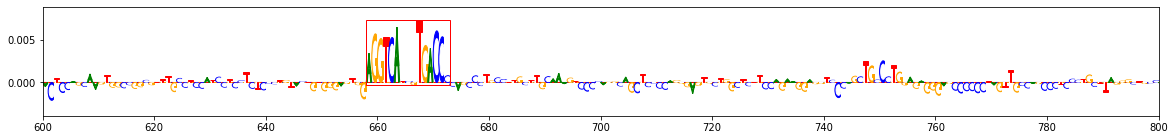

cosine similarity: 0.8567587298175933 sum scores: 0.06570011757612519


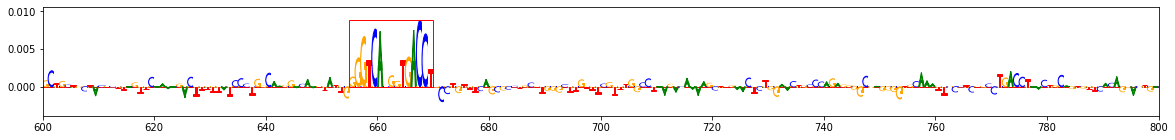

cosine similarity: 0.8678554836664586 sum scores: 0.05605681453798752


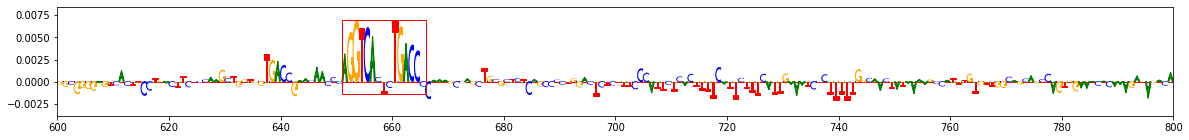

In [28]:
hit_locations = list(zip(*np.nonzero(threshold_passers)))
num_to_viz = 5
for (seq_idx, hit_pos) in hit_locations[:num_to_viz]:
    print("cosine similarity:", masked_cosine_sim[seq_idx,hit_pos],
          "sum scores:", sum_scores[seq_idx, hit_pos])
    fig = plt.figure(figsize=(20,2))
    ax = fig.add_subplot(111)     
    viz_sequence.plot_weights_given_ax(ax=ax,
        array=imp_scores[seq_idx],
        height_padding_factor=0.2,
        length_padding=1.0,
        highlight={'red': [(hit_pos, hit_pos+len(trimmed))]},
        subticks_frequency=20)
    plt.xlim((600,800))
    plt.show()

In [29]:
centered_imps = []
for (seq_idx, hit_pos) in hit_locations:
    centered_imps.append(imp_scores[seq_idx][hit_pos-100:hit_pos+100])
centered_imps = np.array(centered_imps)

counts imp


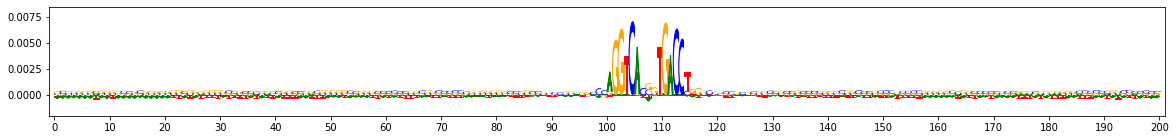

In [30]:
print("counts imp")
viz_sequence.plot_weights(np.mean(centered_imps, axis=0), subticks_frequency=10)

In [31]:
centered_imps.shape

(702, 200, 4)

In [32]:
magnitude_imps = np.sum(centered_imps, axis=-1)

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


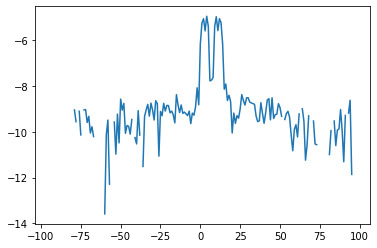

In [33]:
plt.plot(np.arange(-100,100,1), np.log(np.mean(magnitude_imps, axis=0)))

In [ ]:
signal = np.log(np.mean(magnitude_imps, axis=0))
plt.plot(signal[121:181])

In [ ]:
import scipy.signal

L = signal[121:181]
L = np.round(L, 1)
L -= np.mean(L)

In [ ]:
fft = np.fft.rfft(L, norm="ortho")

def abs2(x):
    return x.real**2 + x.imag**2

selfconvol=np.fft.irfft(abs2(fft), norm="ortho")
selfconvol=selfconvol/selfconvol[0]

plt.figure()
plt.plot(selfconvol)
plt.show()

In [ ]:
Ltrunk = L[:44]
plt.plot(Ltrunk)

In [ ]:
fft = np.fft.rfft(Ltrunk, norm="ortho")
selfconvol=np.fft.irfft(abs2(fft), norm="ortho")
selfconvol=selfconvol/selfconvol[0]

plt.figure()
plt.plot(selfconvol)
plt.show()

In [ ]:
5+np.argmax(selfconvol[5:10]), 12+np.argmax(selfconvol[12:20]), 22+np.argmax(selfconvol[22:30]), 30+np.argmax(selfconvol[30:40])

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


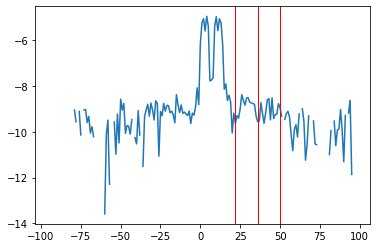

In [40]:
plt.plot(np.arange(-100,100,1), np.log(np.mean(magnitude_imps, axis=0)))
for vline in np.arange(22, 60, 14):
    plt.axvline(x=vline, color='red', linewidth=1.0)

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


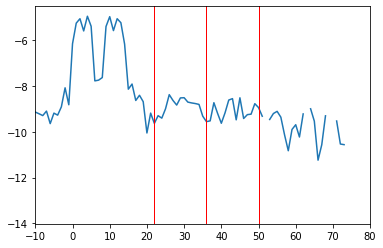

In [41]:
plt.plot(np.arange(-100,100,1), np.log(np.mean(magnitude_imps, axis=0)))
plt.xlim((-10,80))
for vline in np.arange(22, 60, 14):
    plt.axvline(x=vline, color='red', linewidth=1.0)